In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import warnings 
warnings.filterwarnings('ignore')

import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AoIP/train.csv').drop(['id','keyword', 'location' ], axis = 1)
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AoIP/test.csv').drop(['id','keyword', 'location' ], axis = 1)
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Предобработка данных

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from functools import lru_cache

class Text_preproc():
    def __init__(self, language):
        if language == 'english':
            self.bad_reg = re.compile('[^a-z\s\d #]')
            self.stopwords = set(stopwords.words('english'))
            eng_lemmatizer = WordNetLemmatizer()
            @lru_cache(maxsize=10 ** 6)
            def lru_eng_lemmatizer(word):
                return eng_lemmatizer.lemmatize(word)
            self.lemmatizer = lru_eng_lemmatizer
        else:
             raise NotImplementedError('Not supported language')


    def remove_URL(self, text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)


    def remove_html(self, text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)


    def remove_emoji(self, text):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

            
    def __call__(self, text):
        text = self.remove_URL(text)
        text = self.remove_html(text)
        text = self.remove_emoji(text)
        text = text.lower()
        text = re.sub(self.bad_reg, ' ', text)
        text = re.sub('\n|\t', ' ', text)
        text = re.sub(' +', ' ', text)
        lemmas = [self.lemmatizer(word) for word in text.split()]
        lemmas = [word for word in lemmas if word not in self.stopwords]
        
        return ' '.join(lemmas) 

In [5]:
preprocessor = Text_preproc('english')

df_train['clear_text'] = df_train['text'].apply(preprocessor)
df_test['clear_text'] = df_test['text'].apply(preprocessor)

df_train.head()

,text,target,clear_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason #earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive #wildfires evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...


# BERT

BERT — это нейронная сеть, основанная на методе предварительной подготовки контекстных представлений слов, то есть использует двунаправленную модель языка, а также позволяет анализировать целые предложения. В этом случае, учитываются слова, которые идут после данного и через тоже. Этот метод позволяет получать с большим отрывом state-of-the-art результаты в широком спектре задач обработки естественного языка (NLP), но требует больших вычислительных мощностей.

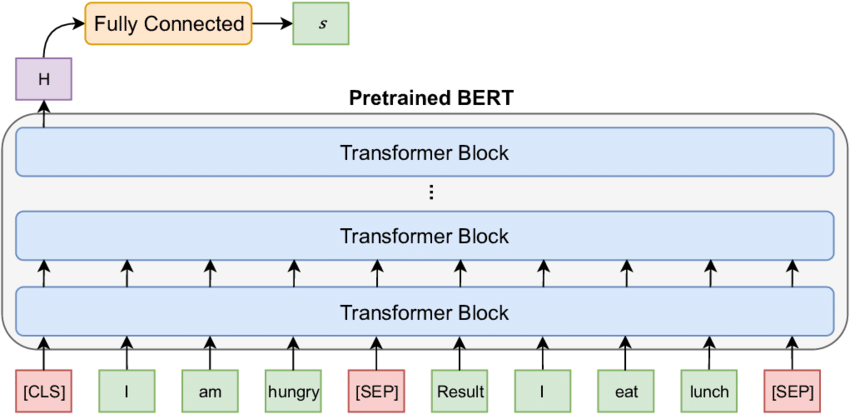

In [6]:
df_train.head()

,text,target,clear_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason #earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive #wildfires evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...


In [7]:
df_test.head()

,text,clear_text
0,Just happened a terrible car crash,happened terrible car crash
1,"Heard about #earthquake is different cities, s...",heard #earthquake different city stay safe eve...
2,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting #spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan


## Добавляем специальные токены [CLS] и [SEP] в начало и конец предложения

In [8]:
text = df_train['clear_text'].values
text = ["[CLS] " + t + " [SEP]" for t in text]

text_test = df_test['clear_text'].values
text_test = ["[CLS] " + t + " [SEP]" for t in text_test]



target = df_train['target'].values

In [10]:
print(text[0])
print(text_test[0])

[CLS] deed reason #earthquake may allah forgive u [SEP]
[CLS] happened terrible car crash [SEP]


## Bert tokenizer

Используем Bert tokenizer для представления текста через набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [11]:
from pytorch_transformers import BertTokenizer, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(t) for t in text]

tokenized_texts_test = [tokenizer.tokenize(t) for t in text_test]

print(tokenized_texts[0])
print(tokenized_texts_test[0])

['[CLS]', 'deed', 'reason', '#', 'earthquake', 'may', 'allah', 'forgive', 'u', '[SEP]']
['[CLS]', 'happened', 'terrible', 'car', 'crash', '[SEP]']


## Входные данные

Подготовим формат входных данных

BERT'у нужно предоставить специальный формат входных данных.

* input ids: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
* labels: вектор из нулей и единиц.
* segment mask: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: нулей и единиц.
* attention mask: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [12]:
from keras.preprocessing.sequence import pad_sequences

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=256,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]

test_inputs = pad_sequences(
    input_ids_test,
    maxlen=256,
    dtype="long",
    truncating="post",
    padding="post"
)

test_masks = np.array([[float(i>0) for i in seq] for seq in test_inputs])

In [13]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, target, 
    random_state=42,
    test_size=0.2
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.2
)

In [14]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

test_inputs = torch.tensor(test_inputs)
test_masks = torch.tensor(test_masks)

## Dataloaders
Создадим torch.utils.data.TensorDataset и сделаем DataLoaders для обучения и предсказания сети

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [19]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=16
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16
)

test_data = TensorDataset(test_inputs, test_masks)
test_dataloader = DataLoader(
    test_data,
    batch_size=16
)

## Предобученный BERT

In [20]:
from pytorch_transformers import AdamW, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).cuda()

print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Обучение модели

Здадим параметры оптимизатора. В качестве оптимизатора используем оптимизатор с регуляризацией весов AdamW

In [21]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [22]:
%%time

from IPython.display import clear_output

train_loss_set = []
train_loss = 0

model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.cuda() for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss[0].item())  
    # Backward pass
    loss[0].backward()
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()
    # Обновляем loss
    train_loss += loss[0].item()
    
print(f'Loss на обучающей выборке: {train_loss / len(train_dataloader)}')

Loss на обучающей выборке: 0.45384997016019396
CPU times: user 8min 40s, sys: 2.67 s, total: 8min 43s
Wall time: 8min 42s


### Тест модели

In [23]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.cuda() for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.hstack(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print(f'Validation Accuracy of the model: {accuracy_score(valid_labels, valid_preds)}')
print(f'Validation Balanced Accuracy of the model: {balanced_accuracy_score(valid_labels, valid_preds)}')

Validation Accuracy of the model: 0.8305975049244911
Validation Balanced Accuracy of the model: 0.81571102170916


### Предсказания по тестовой выборке

In [24]:
model.eval()

test_preds = []

for batch in test_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.cuda() for t in batch)
    
    b_input_ids, b_input_mask = batch
    
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)    
    test_preds.extend(batch_preds)

In [38]:
res = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AoIP/sample_submission.csv')

In [39]:
res['target'] = test_preds
res.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [44]:
res.to_csv('/content/drive/My Drive/Colab Notebooks/AoIP/result_BERT.csv', index=False)